In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-05 04:33:03.665155: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-05 04:33:04.485622: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-05 04:33:04.531954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 04:33:04.532006: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 04:33:04.536529: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 04:33:04.536589: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-05 04:33:04.538315: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

redd_gen_GASF_60m_300S0X_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/redd/TL/redd_82_refit, iawe, eco, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data redd training on model refit seed 82
reading data, printing stats: 
['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404
loading model
compling TL model..


2022-02-05 04:33:05.557789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 04:33:05.558128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-05 04:33:05.558179: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 04:33:05.928570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-05 04:33:05.928605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-05 04:33:05.928616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-05 04:33:05.929179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-05 04:33:06.483542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-05 04:33:06.504486: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-05 04:33:06.992924: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-05 04:33:07.455773: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-05 04:33:07.915395: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 04:33:08.333841: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


907/907 - 16s - loss: 0.9799 - accuracy: 0.6185
Epoch 2/50
907/907 - 14s - loss: 0.6801 - accuracy: 0.7017
Epoch 3/50
907/907 - 14s - loss: 0.5902 - accuracy: 0.7252
Epoch 4/50
907/907 - 14s - loss: 0.5362 - accuracy: 0.7544
Epoch 5/50
907/907 - 14s - loss: 0.4825 - accuracy: 0.7613
Epoch 6/50
907/907 - 14s - loss: 0.4610 - accuracy: 0.7718
Epoch 7/50
907/907 - 14s - loss: 0.4331 - accuracy: 0.7828
Epoch 8/50
907/907 - 14s - loss: 0.4278 - accuracy: 0.7879
Epoch 9/50
907/907 - 15s - loss: 0.3888 - accuracy: 0.7925
Epoch 10/50
907/907 - 14s - loss: 0.4080 - accuracy: 0.7948
Epoch 11/50
907/907 - 15s - loss: 0.3941 - accuracy: 0.7987
Epoch 12/50
907/907 - 14s - loss: 0.3670 - accuracy: 0.7936
Epoch 13/50
907/907 - 14s - loss: 0.3467 - accuracy: 0.8067
Epoch 14/50
907/907 - 14s - loss: 0.3668 - accuracy: 0.8027
Epoch 15/50
907/907 - 14s - loss: 0.3248 - accuracy: 0.8151
Epoch 16/50
907/907 - 15s - loss: 0.3666 - accuracy: 0.8078
Epoch 17/50
907/907 - 14s - loss: 0.3350 - accuracy: 0.8116


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.6177 - accuracy: 0.4266
Epoch 2/50
907/907 - 14s - loss: 1.2762 - accuracy: 0.4568
Epoch 3/50
907/907 - 15s - loss: 1.1152 - accuracy: 0.5793
Epoch 4/50
907/907 - 14s - loss: 1.1686 - accuracy: 0.5116
Epoch 5/50
907/907 - 14s - loss: 1.1931 - accuracy: 0.4774
Epoch 6/50
907/907 - 14s - loss: 1.1767 - accuracy: 0.5561
Epoch 7/50
907/907 - 14s - loss: 1.0968 - accuracy: 0.5197
Epoch 8/50
907/907 - 14s - loss: 1.1376 - accuracy: 0.5535
Epoch 9/50
907/907 - 14s - loss: 1.0596 - accuracy: 0.5851
Epoch 10/50
907/907 - 15s - loss: 1.0471 - accuracy: 0.5885
Epoch 11/50
907/907 - 14s - loss: 0.9897 - accuracy: 0.6049
Epoch 12/50
907/907 - 14s - loss: 1.0732 - accuracy: 0.5576
Epoch 13/50
907/907 - 14s - loss: 1.0118 - accuracy: 0.5838
Epoch 14/50
907/907 - 15s - loss: 1.0119 - accuracy: 0.5341
Epoch 15/50
907/907 - 14s - loss: 0.9778 - accuracy: 0.5597
Epoch 16/50
907/907 - 15s - loss: 0.9807 - accuracy: 0.5392
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.1472 - accuracy: 0.5867
Epoch 2/50
907/907 - 14s - loss: 0.9225 - accuracy: 0.6360
Epoch 3/50
907/907 - 14s - loss: 0.9429 - accuracy: 0.6987
Epoch 4/50
907/907 - 14s - loss: 0.7327 - accuracy: 0.7140
Epoch 5/50
907/907 - 14s - loss: 0.6082 - accuracy: 0.7295
Epoch 6/50
907/907 - 14s - loss: 0.5888 - accuracy: 0.7537
Epoch 7/50
907/907 - 15s - loss: 0.5182 - accuracy: 0.7719
Epoch 8/50
907/907 - 15s - loss: 0.5002 - accuracy: 0.7802
Epoch 9/50
907/907 - 15s - loss: 0.5032 - accuracy: 0.7732
Epoch 10/50
907/907 - 15s - loss: 0.4925 - accuracy: 0.7705
Epoch 11/50
907/907 - 14s - loss: 0.4628 - accuracy: 0.7892
Epoch 12/50
907/907 - 14s - loss: 0.4863 - accuracy: 0.7824
Epoch 13/50
907/907 - 15s - loss: 0.5000 - accuracy: 0.7792
Epoch 14/50
907/907 - 14s - loss: 0.4835 - accuracy: 0.8023
Epoch 15/50
907/907 - 15s - loss: 0.4347 - accuracy: 0.8031
Epoch 16/50
907/907 - 15s - loss: 0.4527 - accuracy: 0.8116
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.1337 - accuracy: 0.5503
Epoch 2/50
907/907 - 14s - loss: 0.7596 - accuracy: 0.6704
Epoch 3/50
907/907 - 14s - loss: 0.6433 - accuracy: 0.7030
Epoch 4/50
907/907 - 14s - loss: 0.5920 - accuracy: 0.7096
Epoch 5/50
907/907 - 14s - loss: 0.5358 - accuracy: 0.7412
Epoch 6/50
907/907 - 14s - loss: 0.5516 - accuracy: 0.7463
Epoch 7/50
907/907 - 14s - loss: 0.4950 - accuracy: 0.7548
Epoch 8/50
907/907 - 15s - loss: 0.4123 - accuracy: 0.7843
Epoch 9/50
907/907 - 14s - loss: 0.4193 - accuracy: 0.7904
Epoch 10/50
907/907 - 14s - loss: 0.3943 - accuracy: 0.8009
Epoch 11/50
907/907 - 15s - loss: 0.3624 - accuracy: 0.8119
Epoch 12/50
907/907 - 14s - loss: 0.3768 - accuracy: 0.8238
Epoch 13/50
907/907 - 14s - loss: 0.3908 - accuracy: 0.8268
Epoch 14/50
907/907 - 15s - loss: 0.3228 - accuracy: 0.8297
Epoch 15/50
907/907 - 14s - loss: 0.3333 - accuracy: 0.8258
Epoch 16/50
907/907 - 14s - loss: 0.3105 - accuracy: 0.8410
Epoch 17/50
907/

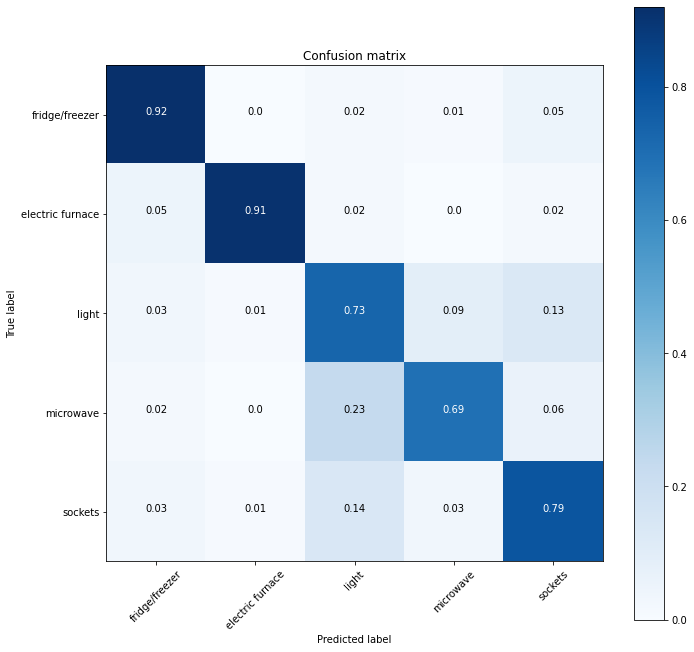

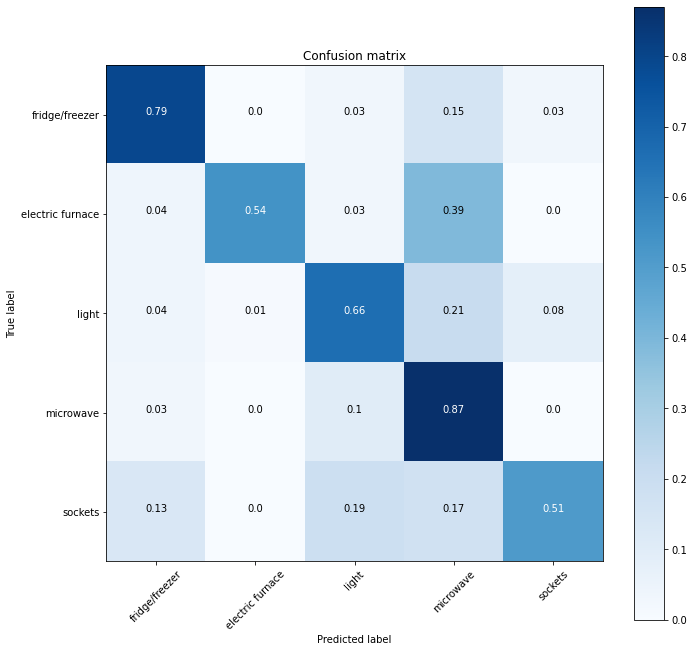

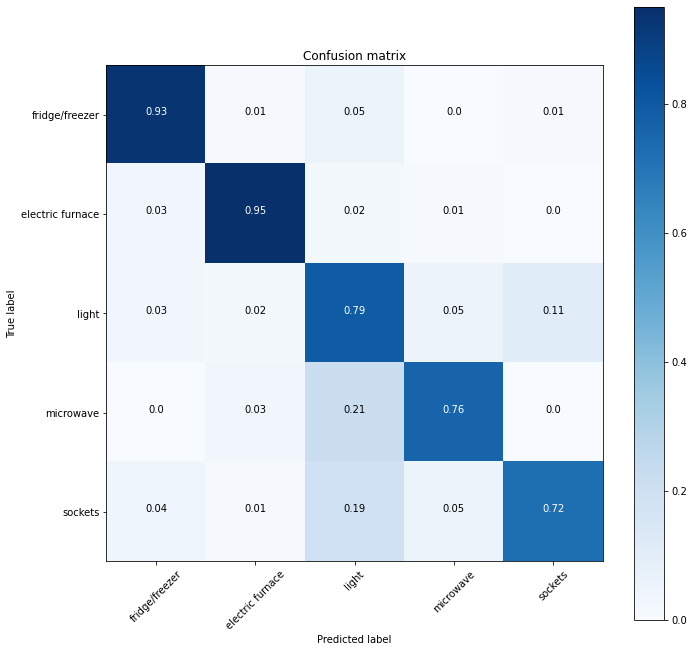

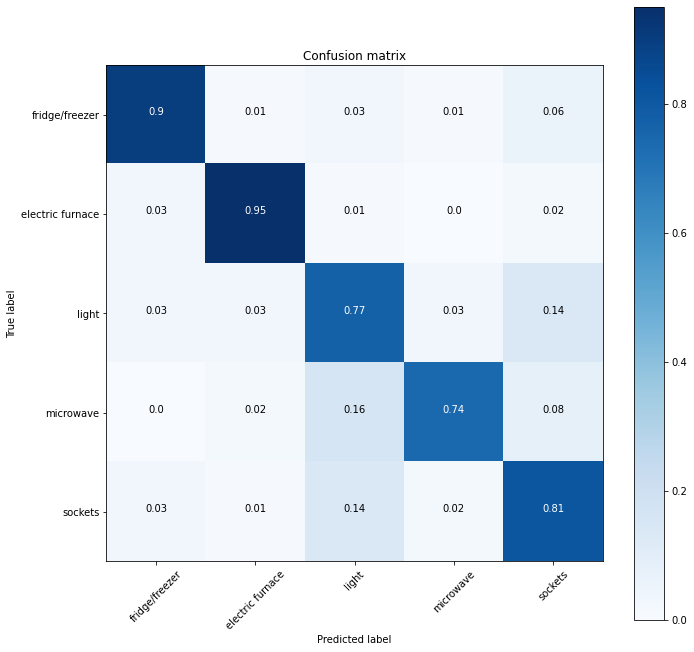

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()